# Classification 

This notebook is for use classifying each of the observed clusters according to the Trumplar system. This is done using three parameters. a) Range of Brightness b) Degree of Concertration c) Cluster Population. Firstly loading required packages and processed data.


In [156]:
import numpy as np 
import pandas as pd 
import os 
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN
from sklearn.datasets import *
import hdbscan
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from astropy import wcs
from astropy.stats import mad_std
from photutils import DAOStarFinder
from astropy.io import fits
from photutils import *

Loading astrometric images and photometry parameters. 

In [75]:
file_list = sorted(glob.glob('astrometric_obs_data/*.fits'))
print(file_list)

['astrometric_obs_data/Bochum2_B_wcs.fits', 'astrometric_obs_data/Bochum2_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 'astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2355_B_wcs.fits', 'astrometric_obs_data/NGC2355_V_wcs.fits', 'astrometric_obs_data/berkeley28_B_wcs.fits', 'astrometric_obs_data/berkeley28_V_wcs.fits']


In [76]:
photo_params = pd.read_csv('calibration_parameters/photo_params.csv') # - loading photometry parameters previously calculated. 
photo_params.head()

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [77]:
def lin_func(x, m, c): # - linear fit for magnitude calibration.
    return m*x + c 

mag_params = pd.read_csv('calibration_parameters/magnitude_processing/magnitude_cal.csv')

,target,slope,constant,slope_err,constant_err
0,berkeley28_B,0.971244,23.975025,0.021307,0.177514
1,berkeley28_V,1.001256,24.526199,0.005840,0.057108
2,Bochum2_B,1.020409,24.677540,0.010366,0.095138
3,Bochum2_V,1.045326,25.174370,0.015138,0.158771
4,NGC2324_B,0.987966,24.082465,0.014919,0.140935


Loading previously defined star finder.

In [78]:
def starfinder(data, fwhm):
    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = 5*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    return mst_sources

Also using previous method of wcs co-ordinates to find simlarities in detection. However, this section of script is edited to calcualte the distance of a detected star from the clusters known center. 

In [135]:
def common_sources(filename_V, filename_B, v_sources_raw, b_sources_raw):
    vhdulist = fits.open(filename_V)
    v_wcs = wcs.WCS(vhdulist[0].header)
    x_cordv = v_sources_raw['xcentroid']; y_cordv = v_sources_raw['ycentroid']
    v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

    bhdulist = fits.open(filename_B)
    x_cordb = b_sources_raw['xcentroid']; y_cordb = b_sources_raw['ycentroid']
    b_wcs = wcs.WCS(bhdulist[0].header)
    b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)
    vcoord_index = []; bcoord_index = []

    v_idx = 0
    for cord in v_cord: 
        sep2tar = cord.separation(b_cord).degree
        if sep2tar.min() < 1.73e-3: 
            vcoord_index.append(v_idx)
            bcoord_index.append(np.argmin(sep2tar))
        v_idx += 1 

    v_sources = v_sources_raw[vcoord_index]; b_sources = b_sources_raw[bcoord_index]

    if len(v_sources) != len(b_sources):
        print('HALT!') 
    else: 
        print('Common Targets:', len(v_sources))

    center =  v_wcs.pixel_to_world(np.shape(vhdulist[0].data)[0]/2, np.shape(vhdulist[0].data)[1]/2)

    sep2cntr = []; v_cord = v_wcs.pixel_to_world(x_cordv[vcoord_index], y_cordv[vcoord_index])
    for star in v_cord: 
        sep2cntr.append(center.separation(star).degree)

    return v_sources, b_sources, np.array(sep2cntr)

Re-incorporating the script for photometry and doing the signal to noise calculation as per data analysis review. 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [80]:
def aper_photometry(data, sources, aper, bkg_counts):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    # Aperture  
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data - bkg_counts, aperture)

    snr = np.array([])

    for col in phot_table.colnames[3:]:
        # bkg_total = bkg_counts*aperture.area
        net_star = phot_table[col] 
        snr = np.append(snr, net_star / np.sqrt(net_star))


    #- Now we get the final table of background subtracted counts for each star
    final_sum = phot_table['aperture_sum']

    return -2.5*np.log10(final_sum), snr

combing all the above steps in a unification function returns, 

In [115]:
def unifi_steps(filename_V, filename_B, table_index):

    data_B = fits.getdata(filename_B); data_V = fits.getdata(filename_V)
    fwhm_B = photo_params['FWHM_B'][table_index]; fwhm_V = photo_params['FWHM_V'][table_index]
    aper_B = photo_params['Aper_B'][table_index]; aper_V = photo_params['Aper_V'][table_index]
    bkg_B = photo_params['bkg_B'][table_index]; bkg_V = photo_params['bkg_V'][table_index]

    raw_B_sources = starfinder(data_B, fwhm_B) # returns list of sources from DAO. 
    raw_V_sources = starfinder(data_V, fwhm_V)

    fil_V_sources, fil_B_sources, seperation_values = common_sources(filename_V, filename_B, raw_V_sources, raw_B_sources) # returns common sources between both B & V filters. 

    mag_V, snr_V = aper_photometry(data_V, fil_V_sources, aper_V, bkg_V)
    mag_B, snr_B = aper_photometry(data_B, fil_B_sources, aper_B, bkg_B)

    return mag_V, mag_B, snr_B, snr_V, fil_V_sources, fil_B_sources, seperation_values

In [116]:
photo_params.head()

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [117]:
mag_params.head()

,target,slope,constant,slope_err,constant_err
0,berkeley28_B,0.971244,23.975025,0.021307,0.177514
1,berkeley28_V,1.001256,24.526199,0.005840,0.057108
2,Bochum2_B,1.020409,24.677540,0.010366,0.095138
3,Bochum2_V,1.045326,25.174370,0.015138,0.158771
4,NGC2324_B,0.987966,24.082465,0.014919,0.140935


This cluster was used for intial tests as it was the poorest documented of the clusters observed. Here error analysis and attempts to classify and fit isochrones.
The instrumental magnitudes were calibrated to the APASS9 catalog (Johnson filters)

$$ \sigma_y =  \sqrt{ x^2 \sigma^2_m + \sigma^2_C + 2x \sigma_m} $$ 

In [104]:
def covariance_propagation(x, slope_err, const_err): 
    return np.sqrt(x**2*slope_err**2 + const_err**2) #+ 2*x*slope_err)

## Berkeley 28 Analysis 

In [144]:
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation = unifi_steps('astrometric_obs_data/Berkeley28_V_wcs.fits', 'astrometric_obs_data/Berkeley28_B_wcs.fits', 2)

mag_Bc = lin_func(mag_B, mag_params['slope'][0], mag_params['constant'][0])
mag_Vc = lin_func(mag_V, mag_params['slope'][1], mag_params['constant'][1])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][1], mag_params['constant_err'][1])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/berkeley28.csv')

print('Average seperation from the center', seperation.mean()*60)

Common Targets: 185
Average seperation from the center 2.9891215664898776


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


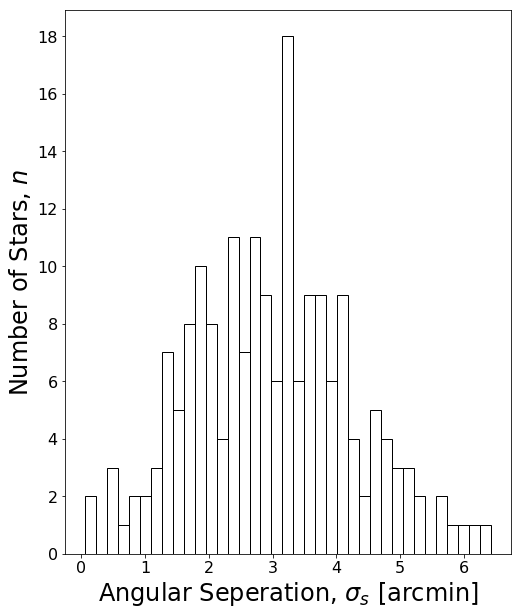

In [161]:
ax = plt.figure(figsize=(8, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

Unique Clusters found 4


/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass min_samples=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


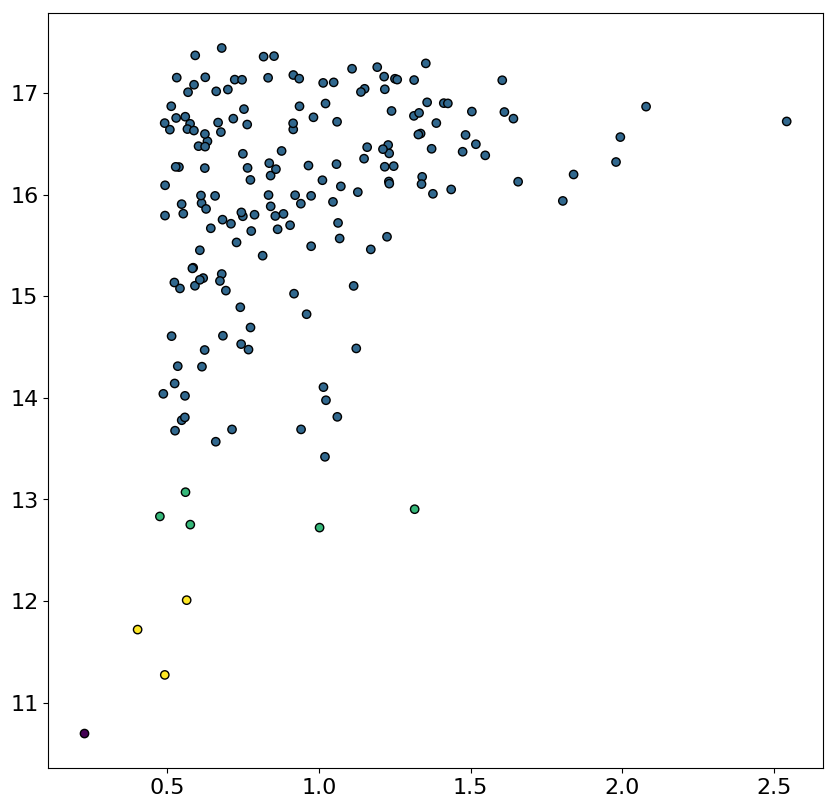

In [163]:
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))



# -- DBSCAN Calculation -- 
preds = dbscan(cmd_data, .5, 2)[1]
dbscanned_data = np.append(cmd_data, preds.reshape(-1,1), axis=1)
scanned_dataframe = pd.DataFrame(dbscanned_data); scanned_dataframe = scanned_dataframe.rename(columns={0: "V_mag", 1: "BV_mag", 2: "cluster_no"})

print('Unique Clusters found', len(np.unique(scanned_dataframe['cluster_no'])))

plt.figure(figsize= (10, 10), dpi=100)
plt.scatter(scanned_dataframe['BV_mag'], scanned_dataframe['V_mag'], c = scanned_dataframe['cluster_no'], edgecolors = 'k', label = scanned_dataframe['cluster_no'])

Unique clusters found: 3


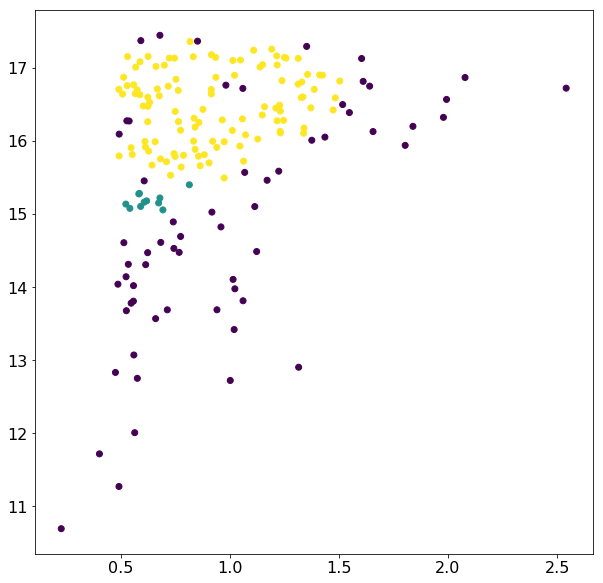

In [164]:
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))

# print(np.shape(cmd_data))

digits = load_digits()
data = digits.data
clusterer = hdbscan.HDBSCAN(min_cluster_size=8).fit(cmd_data)
grouping = clusterer.labels_
print('Unique clusters found:', len(np.unique(grouping)))
probablities = clusterer.probabilities_
# print(probablities)

plt.figure(figsize=(10, 10))
plt.scatter((mag_Bc - mag_Vc), mag_Vc, c = grouping)

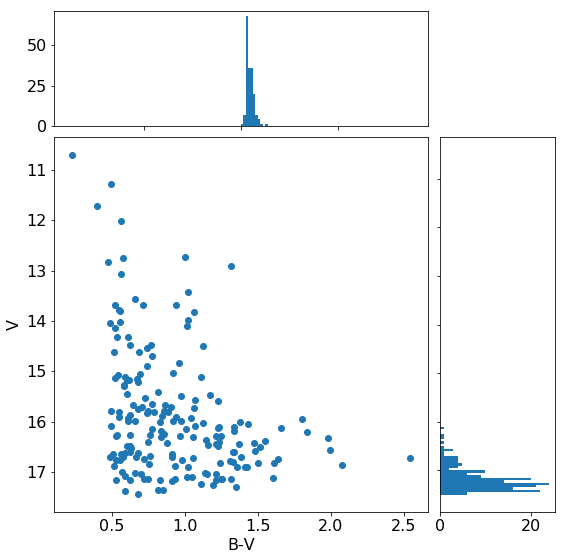

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = '16'


# the data 
x = (mag_Bc - mag_Vc)[~np.isnan(mag_Bc)]
y = mag_Vc[~np.isnan(mag_Bc)]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlabel('B-V')
axScatter.set_ylabel('V')
axScatter.invert_yaxis()

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')
axHisty.invert_yaxis()

# axHistx.set_xlim(axScatter.get_xlim())
# axHisty.set_ylim(axScatter.get_ylim())

plt.show()